In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from common.dataset import ptb
from rnnlm import Rnnlm
from common.time_layers import *
from common.base_model import BaseModel



In [21]:
N=2
H=3
T=20

In [22]:
dh=np.ones((N,H))
np.random.seed(3)

#Wh=np.random.randn(H,H)
Wh=np.random.randn(H,H)*0.5

norm_list=[]
for t in range(T):
    dh=np.matmul(dh,Wh.T)
    norm=np.sqrt(np.sum(dh**2))/N
    norm_list.append(norm)

In [23]:
dW1=np.random.rand(3,3)*10
dW2=np.random.rand(3,3)*10
grads=[dW1,dW2]
max_norm=5.0

def clip_grads(grads,max_norm):
    total_norm=0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate=max_norm/(total_norm+1e-6)
    if rate<1:
        for grad in grads:
            grad*=rate

In [36]:
class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None
        
    def forward(self,x,prev_h,prev_c):
        Wx,Wh,b=self.params
        N,H=prev_h.shape
        
        A=np.matmul(x,Wx)+np.matmul(prev_h,Wh)+b
        
        f=A[:,:H]
        g=A[:,H:2*H]
        i=A[:,2*H:3*H]
        o=A[:,3*H:]
        
        f=sigmoid(f)
        g=np.tanh(g)
        i=sigmoid(i)
        o=sigmoid(o)
        
        next_c=prev_c*f+(g*i)
        next_h=o*np.tanh(next_c)
        
        self.cache=(x,prev_h,prev_c,i,f,g,o,next_c)
        
        return next_h,next_c
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

In [37]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

In [38]:
class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9998.78
| 에폭 1 |  반복 21 / 1327 | 시간 3[s] | 퍼플렉서티 2655.29
| 에폭 1 |  반복 41 / 1327 | 시간 6[s] | 퍼플렉서티 1237.45
| 에폭 1 |  반복 61 / 1327 | 시간 9[s] | 퍼플렉서티 941.49
| 에폭 1 |  반복 81 / 1327 | 시간 12[s] | 퍼플렉서티 779.00
| 에폭 1 |  반복 101 / 1327 | 시간 15[s] | 퍼플렉서티 684.37
| 에폭 1 |  반복 121 / 1327 | 시간 19[s] | 퍼플렉서티 641.92
| 에폭 1 |  반복 141 / 1327 | 시간 22[s] | 퍼플렉서티 587.57
| 에폭 1 |  반복 161 / 1327 | 시간 25[s] | 퍼플렉서티 599.98
| 에폭 1 |  반복 181 / 1327 | 시간 28[s] | 퍼플렉서티 592.07
| 에폭 1 |  반복 201 / 1327 | 시간 31[s] | 퍼플렉서티 509.38
| 에폭 1 |  반복 221 / 1327 | 시간 34[s] | 퍼플렉서티 496.71
| 에폭 1 |  반복 241 / 1327 | 시간 38[s] | 퍼플렉서티 446.80
| 에폭 1 |  반복 261 / 1327 | 시간 41[s] | 퍼플렉서티 462.97
| 에폭 1 |  반복 281 / 1327 | 시간 44[s] | 퍼플렉서티 448.81
| 에폭 1 |  반복 301 / 1327 | 시간 47[s] | 퍼플렉서티 395.51
| 에폭 1 |  반복 321 / 1327 | 시간 50[s] | 퍼플렉서티 346.43
| 에폭 1 |  반복 341 / 1327 | 시간 53[s] | 퍼플렉서티 400.08
| 에폭 1 |  반복 361 / 1327 | 시간 56[s] | 퍼플렉서티 407.94
| 에폭 1 |  반복 381 / 1327 | 시간 60[s] | 퍼플렉서티 340.86
| 에폭 1 

| 에폭 3 |  반복 541 / 1327 | 시간 494[s] | 퍼플렉서티 136.09
| 에폭 3 |  반복 561 / 1327 | 시간 497[s] | 퍼플렉서티 120.28
| 에폭 3 |  반복 581 / 1327 | 시간 500[s] | 퍼플렉서티 105.95
| 에폭 3 |  반복 601 / 1327 | 시간 503[s] | 퍼플렉서티 149.61
| 에폭 3 |  반복 621 / 1327 | 시간 506[s] | 퍼플렉서티 143.01
| 에폭 3 |  반복 641 / 1327 | 시간 509[s] | 퍼플렉서티 130.12
| 에폭 3 |  반복 661 / 1327 | 시간 512[s] | 퍼플렉서티 122.28
| 에폭 3 |  반복 681 / 1327 | 시간 515[s] | 퍼플렉서티 99.31
| 에폭 3 |  반복 701 / 1327 | 시간 518[s] | 퍼플렉서티 119.92
| 에폭 3 |  반복 721 / 1327 | 시간 521[s] | 퍼플렉서티 127.26
| 에폭 3 |  반복 741 / 1327 | 시간 524[s] | 퍼플렉서티 108.13
| 에폭 3 |  반복 761 / 1327 | 시간 527[s] | 퍼플렉서티 103.49
| 에폭 3 |  반복 781 / 1327 | 시간 530[s] | 퍼플렉서티 105.59
| 에폭 3 |  반복 801 / 1327 | 시간 532[s] | 퍼플렉서티 116.10
| 에폭 3 |  반복 821 / 1327 | 시간 535[s] | 퍼플렉서티 117.15
| 에폭 3 |  반복 841 / 1327 | 시간 538[s] | 퍼플렉서티 114.42
| 에폭 3 |  반복 861 / 1327 | 시간 541[s] | 퍼플렉서티 120.43
| 에폭 3 |  반복 881 / 1327 | 시간 544[s] | 퍼플렉서티 106.58
| 에폭 3 |  반복 901 / 1327 | 시간 547[s] | 퍼플렉서티 130.66
| 에폭 3 |  반복 921 / 1327 | 시간 550

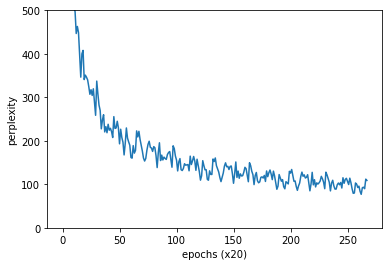

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.04847433355158


In [39]:
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()